This tries to improve on the basic random forest classifier by adding another feature. It identifies the edges in the image and then counts the number of separate edge curves.

In [4]:
import pandas as pd
import numpy as np
from skimage.viewer import ImageViewer
from skimage.feature import canny
from skimage.measure import label
from imageviewing import series_to_array
from imageviewing import view_series
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.stats import ttest_ind
#import matplotlib.pyplot as plt
#from sklearn.cross_validation import train_test_split

/usr/local/lib/python2.7/dist-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [5]:
#%matplotlib qt
%matplotlib inline

In [6]:
with open('datapath.txt') as f:
    datapath=f.readlines()[0].rstrip()

In [7]:
train=pd.read_csv(datapath+'/train.csv', nrows=10, dtype=np.uint8)
pixels=train.columns.drop('label')


In [14]:
len(train['label'].shape)

1

### Compute the edge count

In [44]:
def bw_series_array(series,pixel=None):
    """Takes an image in pandas series form and returns an array where all non-black 
    pixels are changed to completely white. Note that even if the color is really
    close to black, it still gets categorized as white as long as it's not pure black."""
    return series_to_array((series>0).astype(np.uint8),pixel_columns=pixel)*255

In [6]:
def bw_canny(series,pixel=None):
    """Applies a canny filter to the black and white image. 
    This returns an image of the edges of the original image"""
    bw_array=bw_series_array(series,pixel=pixel)
    return canny(bw_array)

In [7]:
def num_bw_edges(series,pixel=None):
    """Counts the number of edges in a pandas series image"""
    return label(bw_canny(series,pixel=pixel),return_num=True)[1]

In [8]:
%time bw_edges=train.apply(lambda x: num_bw_edges(x, pixel=pixels),axis=1)

CPU times: user 56.2 s, sys: 8.06 ms, total: 56.2 s
Wall time: 56.2 s


### Classify

In [9]:
rfc=RandomForestClassifier(max_features=0.1,min_samples_split=6,min_weight_fraction_leaf=0.0,n_estimators=200)

In [13]:
bw_edges_error=cross_val_score(rfc,pd.concat([train[pixels],bw_edges],axis=1),train['label'],cv=5)

In [25]:
#Yes, I'm using pandas to read a simple, 5 row csv. Get over it.
simple_error=pd.read_csv(datapath+'/simple_random_forest_cv_error.csv',header=None)[1].values

In [45]:
print('Error difference is %1.5f, which is %1.0f more images correct.' % (bw_edges_error.mean()-simple_error.mean(), (bw_edges_error.mean()-simple_error.mean())*train.shape[0]))
print('p-value = %1.3E' % ttest_ind(simple_error,bw_edges_error).pvalue)

Error difference is 0.00307, which is 129 more images correct.
p-value = 2.540E-02


The difference is pretty small. We only get 129 more of these correct.  It is statistically significant enough to say that we can discard the null hypothesis that the edge count doesn't matter.

Note that this isn't a 100% fair comparison. The parameters for the Random Forest were fit to the raw pixel data, and I didn't do the same GridSearchCV on the data with the edge data, but I doubt it would make that much of a difference.

In [50]:
rfc.fit(pd.concat([train[pixels],bw_edges],axis=1),train['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

While the edge feature is the most important (it's labeled `0` below), it's only about 3 times more important than the most important single pixel, which isn't all that much.

In [62]:
columns=pd.concat([train[pixels],bw_edges],axis=1).columns
importances=rfc.feature_importances_
[(columns[i], importances[i]) for i in importances.argsort()[::-1]][:10]

[(0, 0.042782281181513088),
 ('pixel378', 0.014009126072613931),
 ('pixel350', 0.012372231564120715),
 ('pixel433', 0.010584838123553365),
 ('pixel409', 0.010582859393558857),
 ('pixel437', 0.010526238751740158),
 ('pixel155', 0.0093676947526647857),
 ('pixel461', 0.0090838164255740497),
 ('pixel489', 0.008334425859451074),
 ('pixel462', 0.0080746833827235569)]

### Looking at the edge count data

In [35]:
label_edges=pd.concat([bw_edges,train[['label','pixel0']]],axis=1)
label_edges.columns=['edges','label','pixel0']

label
0    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
1    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
2    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
3    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
4    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
5    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
6    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
7    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
8    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
9    [[Axes(0.125,0.125;0.336957x0.775), Axes(0.563...
dtype: object

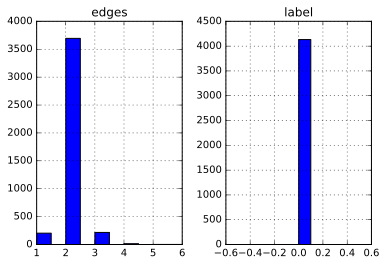

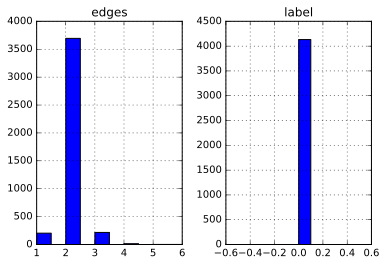

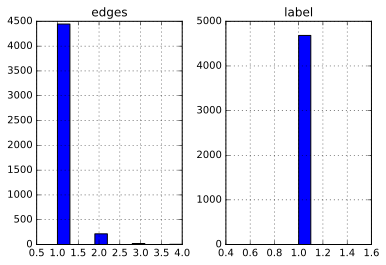

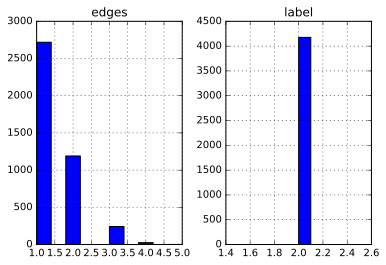

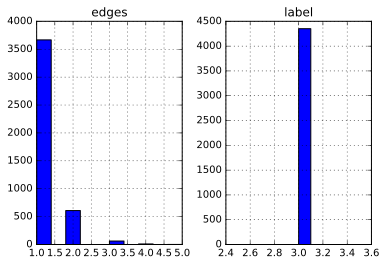

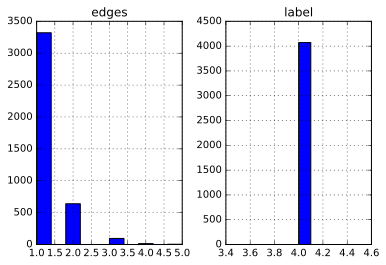

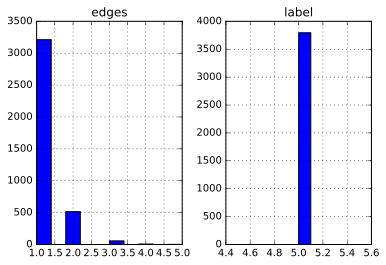

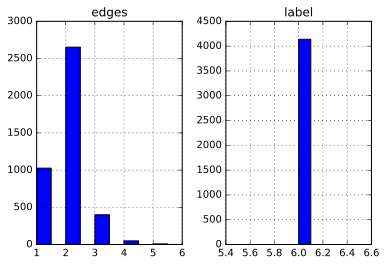

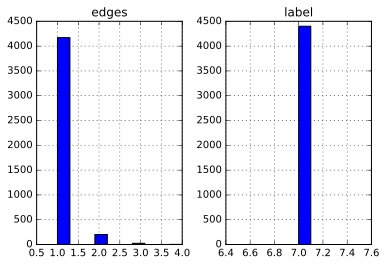

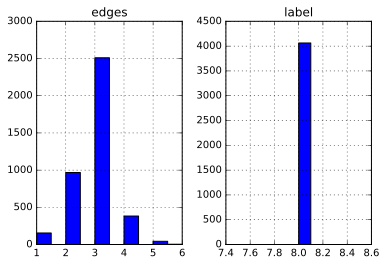

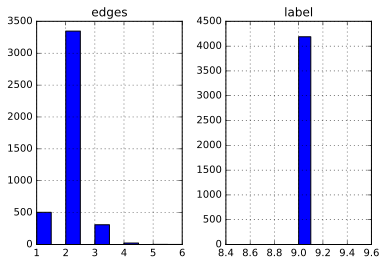

In [36]:
label_edges[['edges','label']].groupby(['label']).apply(lambda x: x.hist())

    

I know that might not be all that straightforward, but those are histograms of the number of counted edge shapes, sorted by the proper label. You can see that there is a lot of noise here.

We would expect the number 8, at least, to be pretty consistent, as everyone pretty much writes it the same. It still has a bunch of images with more or less than the normal 3 edges.

We can see that this is far from a perfect predictor. It might need a little bit of work. 

Here is what I think is going wrong:

Over-estimated edge count:
- images with splotches off of the normal shape which we could probably remove.
- Single pixels inside the shape where there just happen to be black dots.
- Little extra lines and curves that close with the main shape.

Under-estimated edge count:
- People fail to close their loops.
- Loops are so small that they don't have a clear black area inside of them.

It could be that adding in some more features on this theme might improve it. When converting the image to black and white, we could probably use some threshold gray value, instead of just turning all non-black pixels white.

### Looking at the funky images

`scikit-image`'s image viewer doesn't work with the inline display in the jupyter notebook, but if you want to take a look at some of these images, the cells below show 8's with only two counted edges. 

You can change the value in the `loc` to look at the corresponding value. 131 is particularly funky looking.

In [61]:
viewer=view_series(train.loc[131])
viewer.show()

[]

The code below shows an image of the computed edges.

In [60]:
viewer=ImageViewer(bw_canny(train.loc[131]))
viewer.show()

[]

In [40]:
train[(train['label']==8)&(bw_edges==2)]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
131,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
268,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
449,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
